In [1]:
from numba import njit
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp # Besserer Integrator
from scipy.signal import find_peaks
from itertools import product

In [2]:
l = 300
beta0 = 0.5 #days^-1
gamma = 0.1 #days^-1
nu = 1/100 #days^-1
T_range = [1,100] #days
p_base_range = (0.01, 0.4)

p_cap = 1e-3
epsilon = 1e-4
s = 0. # seasonal forcing
omega = 2 * np.pi / 360 #days⁻1

maxVax = 0.01 # Von N0 können pro tag geimpft werden

p_vax = 1000 # Anteil der Leute, die angst haben und sich deswegen Impfen lassen wollen
mu_im = 1/14 #1/days


T = np.linspace(T_range[0], T_range[1], num=l)
p_base = np.linspace(p_base_range[0], p_base_range[1], num=l, endpoint=True)
params = np.array(list(product(T, p_base))).T
T = params[0]
p_base = params[1]


In [3]:
@njit
def P(H):
    return p_base + (1-p_base)/p_cap * epsilon * np.log(1+np.exp(1/epsilon * (p_cap - H)))

@njit
def vax(H):
    return (1- np.exp(-p_vax*H))* maxVax

@njit
def Gamma(t):
    return 1+ s* np.cos(omega*t)

def odes(t, p, T, p_base):
    S = p[:l*l]
    V = p[l*l:2*l*l]
    V1 = p[2*l*l:3*l*l]
    I = p[3*l*l:4*l*l]
    H_1 = p[4*l*l:5*l*l]
    H = p[5*l*l:6*l*l]
    R = p[6*l*l:7*l*l]
    #R = 1-S-I -V - V1
    
    dS = - beta0 * P(H) * Gamma(t) * I * S + nu * (R+V) - vax(H) * S
    dV =  V1 * mu_im - nu * V
    dV1 = vax(H) * S - V1 * mu_im - beta0 * P(H) * Gamma(t) * I * V1 #TODO die hier muessen noch infiziert werden
    
    dI = beta0 * P(H) * Gamma(t) * I * (S+V1) - gamma * I 
    dR = gamma*I - nu*R
    dH_1 = 2/T * (I - H_1)
    dH = 2/T * (H_1 - H)
    
    return np.concatenate((dS,dV, dV1, dI,dH_1, dH, dR))

@njit
def quedenker_odes(t, p, T, p_base):
    S = p[:l*l]
    I = p[l*l:2*l*l]
    H_1 = p[2*l*l:3*l*l]
    H = p[3*l*l:4*l*l]
    R = p[4*l*l:5*l*l]

    dS = - beta0 * P(H) * Gamma(t) * I * S + nu * R
    
    dI = beta0 * P(H) * Gamma(t) * I * (S) - gamma * I 
    dR = gamma*I - nu*R
    dH_1 = 2/T * (I - H_1)
    dH = 2/T * (H_1 - H)
    
    return np.concatenate((dS, dI,dH_1, dH, dR))

In [4]:
I0 = 0.0045 * np.ones(l*l)
S0 = 0.65*np.ones(l*l)
H_10 = 0.0015 * np.ones(l*l)
H0 = 0.0015 * np.ones(l*l)
V0 = 0.4 *np.ones(l*l)
V10=0.05 *np.ones(l*l)
R0 = np.zeros(l**2)
p0 = np.concatenate((S0, V0, V10, I0, H_10, H0, R0))
querdenkerP0 = np.concatenate((S0, I0, H_10, H0, R0))

print(len(p0))

630000


In [5]:
maxdt = 1
sol = solve_ivp(odes, (0,10000), p0, max_step=maxdt, args=(T,p_base), t_eval=range(8000,10000))


In [6]:
p = sol.y
ts = sol.t

Ss = p[:l*l]
Vs = p[l*l:2*l*l]
V1s = p[2*l*l:3*l*l]
Is = p[3*l*l:4*l*l]
H_1s= p[4*l*l:5*l*l]
Hs = p[5*l*l:6*l*l]
Rs = p[6*l*l:7*l*l]

In [7]:
karte = np.zeros((l,l))

for n in range(l):
    for m in range(l):
        i = n*l+m
        t = ts
        S = Ss[i]
        V = Vs[i]
        V1 = V1s[i]
        I = Is[i]
        H_1 = H_1s[i]
        H = Hs[i]
        R = Rs[i]
        peaks = find_peaks(I)
        
        if len(peaks[0])>0:
            karte[-n-1, m] = 1
        else:
            karte[-n-1, m] = -1
            

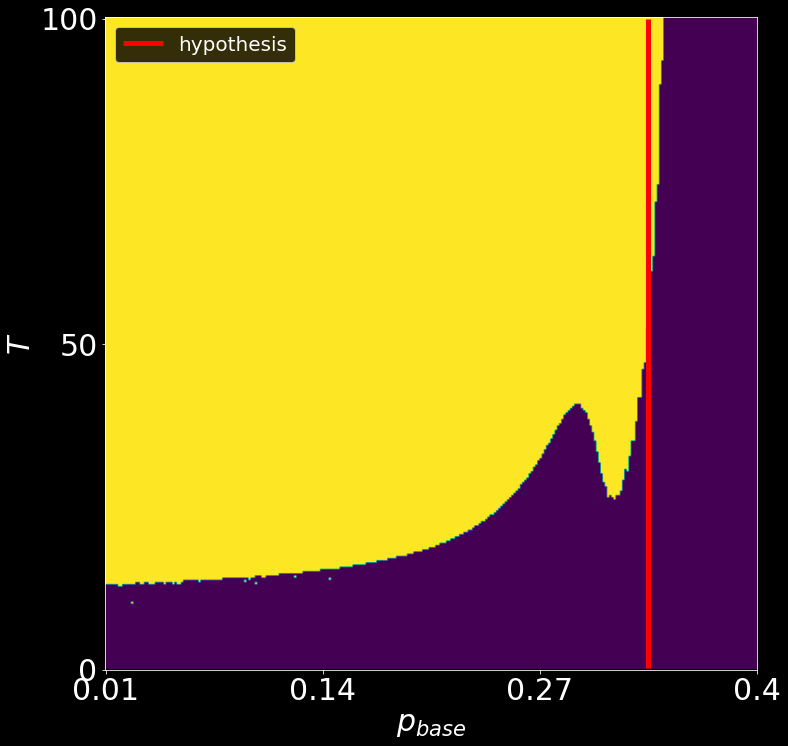

In [29]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(karte)
plt.vlines(p_b/0.4*300,0,299,colors='r',lw=5,label="hypothesis")
plt.yticks([0,150,300], [100,50,0],fontsize=30, rotation=0)
plt.xticks([0,100, 200, 300], [0.01,0.14,0.27,0.40],fontsize=30, rotation=0)
plt.xlabel("$p_{base}$", size = 30)
plt.ylabel("$T$", size = 30)
R_v = 5 * 0.6
#p_b = 1/(R_v)

#plt.vlines(0.33/0.4*300,0,299,colors='b',lw=5,label="hypothesis")
plt.legend(fontsize=20,loc='upper left')
#cbar = plt.colorbar()

#for t in cbar.ax.get_yticklabels():
#     t.set_fontsize(20)
#cbar.set_label('# of peaks', loc ='center', rotation=270, fontsize=30,labelpad=30)
plt.savefig("1307Result300x300PBase=0.4_fancy_20.png")